In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [3]:
import json, os, shutil, random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from PIL import Image

In [4]:
# Define the categories.
categories = ['shoes', 'clothing', 'accessories', 'bags']
categories.sort()

1. Preprocess the '【AiDLab】A100' dataset and save extracted files to the 'dataset' folder.

In [5]:
def preprocess_dataset(categories):

    # Classify the AAT dataset.
    classified_image_paths = {category: [] for category in categories}
    with open('【AiDLab】A100/AAT/label/AAT.json') as file:
        content = file.read()
    ls = []
    for dic in json.loads(content):
        ls.extend(dic['answers'])
        ls.extend(dic['question'])
    for s in ls:
        image_path = s[-6:] + '.jpg'
        match s[0]:
            case 'S':
                classified_image_paths['shoes'].append(image_path)
            case 'C':
                classified_image_paths['clothing'].append(image_path)
            case 'A':
                classified_image_paths['accessories'].append(image_path)
            case 'B':
                classified_image_paths['bags'].append(image_path)

    # Split the AAT dataset.
    for category in categories:
        image_paths = classified_image_paths[category]
        random.shuffle(image_paths)
        splitted_image_paths = {
            'train': image_paths[:int(0.6 * len(image_paths))],
            'validate': image_paths[int(0.6 * len(image_paths)):int(0.8 * len(image_paths))],
            'test': image_paths[int(0.8 * len(image_paths)):]
        }
        for phase, image_paths in splitted_image_paths.items():
            os.makedirs(os.path.join('dataset', phase, category), exist_ok=True)
            for image_path in image_paths:
                source = os.path.join('【AiDLab】A100/AAT/image', image_path)
                destination = os.path.join('dataset', phase, category, image_path)
                shutil.copyfile(source, destination)

    # Classify the LAT dataset.
    classified_image_paths = {category: [] for category in categories}
    with open('【AiDLab】A100/LAT/label/LAT.json') as file:
        content = file.read()
    ls = []
    for dic in json.loads(content):
        ls.extend(dic['answers'])
        ls.extend(dic['question'])
    image_paths = []
    for s in ls:
        image_path = s[-9:] + '.jpg'
        image_paths.append(os.path.join('【AiDLab】A100/LAT/image', image_path))
        match s[0:2]:
            case 'Sh':
                classified_image_paths['shoes'].append(image_path)
            case 'Pa' | 'Ou' | 'To' | 'Sk' | 'Dr':
                classified_image_paths['clothing'].append(image_path)
            case 'Ea' | 'Wa' | 'Br' | 'Ne' | 'Ha' | 'Su':
                classified_image_paths['accessories'].append(image_path)
            case 'Ba':
                classified_image_paths['bags'].append(image_path)
    for category in categories:
        image_paths = classified_image_paths[category]
        os.makedirs(os.path.join('dataset', 'test_random', category), exist_ok=True)
        for image_path in image_paths:
            source = os.path.join('【AiDLab】A100/LAT/image', image_path)
            destination = os.path.join('dataset', 'test_random', category, image_path)
            shutil.copyfile(source, destination)


# Preprocess the dataset.
print('Dataset preprocessing starts.')
preprocess_dataset(categories)
print('Dataset preprocessing ends.')

Dataset preprocessing starts.
Dataset preprocessing ends.


2. Augment and load the dataset.

In [6]:
# Define the transformation.
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validate': transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load the dataset.
dataset = {
    'train': datasets.ImageFolder(root='dataset/train', transform=transform['train']),
    'validate': datasets.ImageFolder(root='dataset/validate', transform=transform['validate']),
    'test': datasets.ImageFolder(root='dataset/test', transform=transform['test'])
}

# Define the data loaders.
batch_size = 64
train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(dataset['validate'], batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False)

In [7]:
# Set the device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the MobileNetV2 model.
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.last_channel, len(categories))
)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 71.9MB/s]


In [8]:
# Define the loss function.
criterion = nn.CrossEntropyLoss()

# Define the optimizer.
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the learning rate scheduler.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


3. Train and validate the network.

In [9]:
def train_and_validate(device, model, train_loader, validate_loader, criterion, optimizer, scheduler, epochs):
    train_losses, train_accuracies = [], []
    validate_losses, validate_accuracies = [], []
    print('Training and validation start.')
    best_validate_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        # Train the network.
        model.train()
        running_loss = 0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs.data, 1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
        train_loss = running_loss / total
        train_losses.append(train_loss)
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)
        print(f'\tTraining loss: {train_loss:.4f}\tTraining accuracy: {train_accuracy:.4f}')

        # Validate the network.
        model.eval()
        running_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in validate_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, predictions = torch.max(outputs.data, 1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)
        validate_loss = running_loss / total
        validate_losses.append(validate_loss)
        validate_accuracy = correct / total
        validate_accuracies.append(validate_accuracy)
        print(f'\tValidation loss: {validate_loss:.4f}\tValidation accuracy: {validate_accuracy:.4f}')

        # Check the early stopping.
        if validate_loss < best_validate_loss:
            patience_counter = 0
            best_validate_loss = validate_loss
            # Save the best model.
            torch.save(model.state_dict(), 'model.pth')
        else:
            patience_counter += 1
            if patience_counter == 10:
                break
    print('Training and validation end.')
    return train_losses, validate_losses, train_accuracies, validate_accuracies


# Train and validate the network.
epochs = 50
train_losses, validate_losses, train_accuracies, validate_accuracies = train_and_validate(device, model, train_loader, validate_loader, criterion, optimizer, scheduler, epochs)

Training and validation start.
Epoch 1/50
	Training loss: 1.2106	Training accuracy: 0.4940
	Validation loss: 0.8254	Validation accuracy: 0.7929
Epoch 2/50
	Training loss: 0.6807	Training accuracy: 0.7888
	Validation loss: 0.5177	Validation accuracy: 0.8535
Epoch 3/50
	Training loss: 0.3984	Training accuracy: 0.8722
	Validation loss: 0.4263	Validation accuracy: 0.8636
Epoch 4/50
	Training loss: 0.2715	Training accuracy: 0.9114
	Validation loss: 0.3733	Validation accuracy: 0.8687
Epoch 5/50
	Training loss: 0.1741	Training accuracy: 0.9608
	Validation loss: 0.3369	Validation accuracy: 0.8939
Epoch 6/50
	Training loss: 0.1240	Training accuracy: 0.9727
	Validation loss: 0.3248	Validation accuracy: 0.8990
Epoch 7/50
	Training loss: 0.0945	Training accuracy: 0.9761
	Validation loss: 0.3197	Validation accuracy: 0.8990
Epoch 8/50
	Training loss: 0.0758	Training accuracy: 0.9864
	Validation loss: 0.3225	Validation accuracy: 0.8939
Epoch 9/50
	Training loss: 0.0630	Training accuracy: 0.9864
	Vali

4. Plot the loss and accuracy curves.

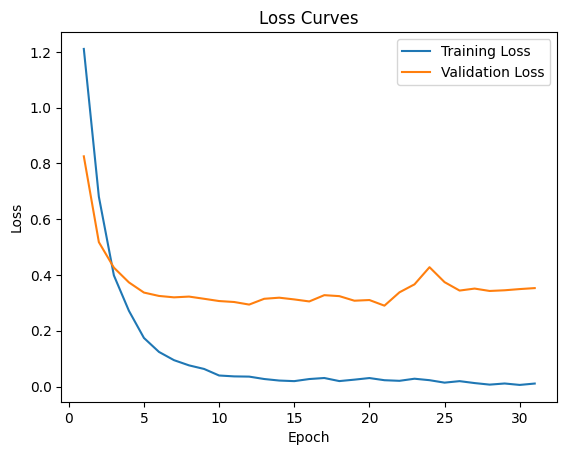

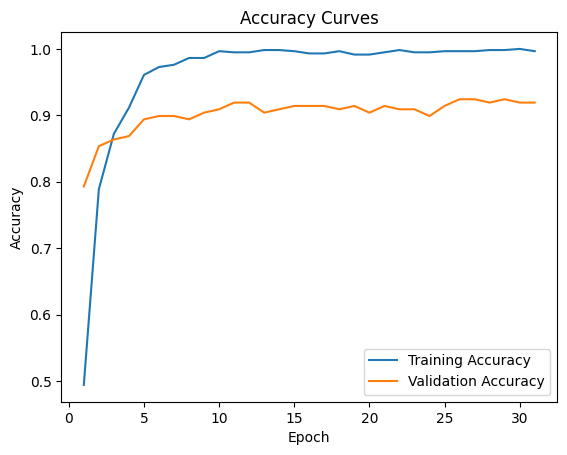

In [10]:
def plot_loss(epochs, train_losses, validate_losses):
    plt.figure()
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, validate_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def plot_accuracy(epochs, train_accuracies, validate_accuracies):
    plt.figure()
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, validate_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


# Plot the loss curves.
plot_loss(range(1, len(train_losses) + 1), train_losses, validate_losses)

# Plot the accuracy curves.
plot_accuracy(range(1, len(train_accuracies) + 1), train_accuracies, validate_accuracies)

5. Test the network.

In [11]:
def test(device, model, test_loader, criterion, categories):
    cm_labels = []
    cm_predictions = []
    print('Test starts.')
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs.data, 1)
            cm_labels.extend(labels.cpu().numpy())
            cm_predictions.extend(predictions.cpu().numpy())
    print(metrics.classification_report(cm_labels, cm_predictions, target_names=categories))
    print('Test ends.')
    return cm_labels, cm_predictions


 # Test the network.
cm_labels, cm_predictions = test(device, model, test_loader, criterion, categories)

Test starts.
              precision    recall  f1-score   support

 accessories       0.96      0.97      0.96        67
        bags       0.97      0.85      0.91        34
    clothing       0.89      0.97      0.93        60
       shoes       1.00      0.95      0.97        37

    accuracy                           0.94       198
   macro avg       0.95      0.93      0.94       198
weighted avg       0.95      0.94      0.94       198

Test ends.


6. Plot the confusion matrix.

In [ ]:
def plot_confusion_matrix(cm_labels, cm_predictions, categories):
    plt.figure()
    cm = metrics.confusion_matrix(cm_labels, cm_predictions)
    metrics.ConfusionMatrixDisplay(cm, display_labels=categories).plot()
    plt.title('Confusion Matrix')
    plt.show()


# Plot the confusion matrix.
plot_confusion_matrix(cm_labels, cm_predictions, categories)

7. Test a random data point from another dataset. (You can run this cell several times for test different images.)

Random test starts.


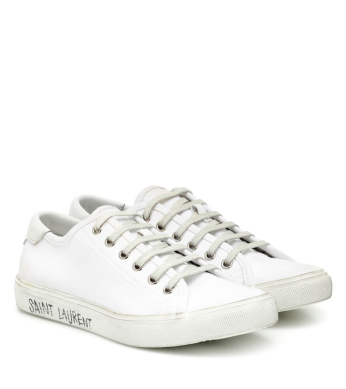

Predicted category: shoes
Random test ends.

Test starts.
              precision    recall  f1-score   support

 accessories       0.93      0.94      0.94        88
        bags       0.98      0.98      0.98       120
    clothing       0.99      0.98      0.98       341
       shoes       0.99      0.99      0.99       131

    accuracy                           0.98       680
   macro avg       0.97      0.97      0.97       680
weighted avg       0.98      0.98      0.98       680

Test ends.


<Figure size 640x480 with 0 Axes>

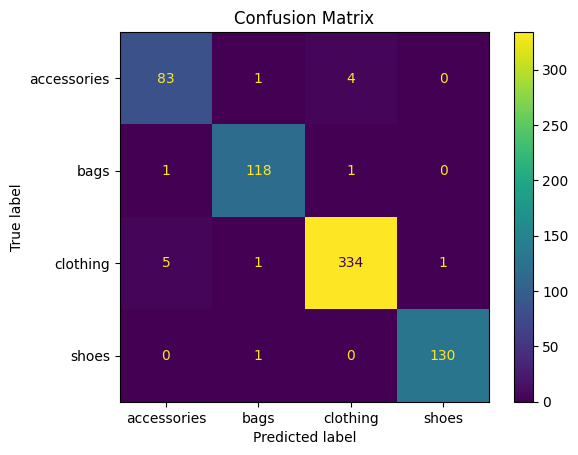

In [13]:
def test_random(device, model, categories, transform):
    print('Random test starts.')
    # Load a random image.
    image_paths = []
    for category in categories:
        image_path = [os.path.join('dataset', 'test_random', category, p) for p in os.listdir(os.path.join('dataset', 'test_random', category))]
        image_paths.extend(image_path)
    image = Image.open(random.choice(image_paths))

    # Show the image.
    plt.figure()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Transform the image.
    image = transform['test'](image).unsqueeze(0)

    # Test the network.
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        _, prediction = torch.max(output.data, 1)
    predicted_category = categories[prediction.item()]
    print(f'Predicted category: {predicted_category}')
    print('Random test ends.\n')


# Test a random data point from another dataset.
test_random(device, model, categories, transform)

# Test the whole dataset.
test_random_dataset = datasets.ImageFolder(root='dataset/test_random', transform=transform['test'])
test_random_loader = DataLoader(test_random_dataset, batch_size=batch_size, shuffle=False)
cm_labels, cm_predictions = test(device, model, test_random_loader, criterion, categories)
plot_confusion_matrix(cm_labels, cm_predictions, categories)